# BreastCancer Diagnostic with Perceptron

In [1]:
import pandas as pd # for loading data csv into dataframe and cleaning data
import os # for building url path
import numpy as np 
import matplotlib.colors # will use ListedColorMap to plot results
import matplotlib.pyplot as pp

## Read in cancer data from the machine learning database

In [135]:
cancer_data_url = os.path.join ('https://archive.ics.uci.edu', 'ml', 'machine-learning-databases', 'breast-cancer-wisconsin', 'breast-cancer-wisconsin.data')
cancer_data = pd.read_csv(cancer_data_url, header=None, encoding='utf-8')
cancer_data.columns = ['id', 'thickness', 'size uniformity', # assign columns more useful names
                       'shape uniformity', 'marginal adhesion',
                       'epi cell size', 'bare nuclei', 'bland chromatin',
                       'normal nucleoi', 'mitoses', 'class']
cancer_data.head()

,id,thickness,size uniformity,shape uniformity,marginal adhesion,epi cell size,bare nuclei,bland chromatin,normal nucleoi,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


## Helper method to plot the correlation between two features

In [3]:
def plot_classes_by_columns(super_plot, frame, c1, c2, num=2, denom=3):
    malignants = frame.loc[frame['class'] == 4]
    benigns = frame.loc[frame['class'] == 2]
    
    num_maligns = int((len(malignants.index) / denom) * num)
    num_benigns = int((len(benigns.index) / denom) * num)
    
    super_plot.scatter(malignants[c1].values[:num_maligns], malignants[c2].values[:num_maligns], color='red', marker='o', label='malignant')
    super_plot.scatter(benigns[c1].values[:num_benigns], benigns[c2].values[:num_benigns], color='blue', marker='x', label='benign')

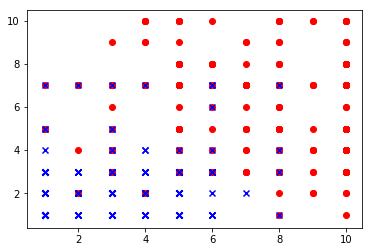

In [122]:
plot_classes_by_columns(pp, cancer_data, 'thickness', 'bland chromatin', num=1, denom=1)

## Plot the correlation for every unique pair of features (see which will be most linearly separable)

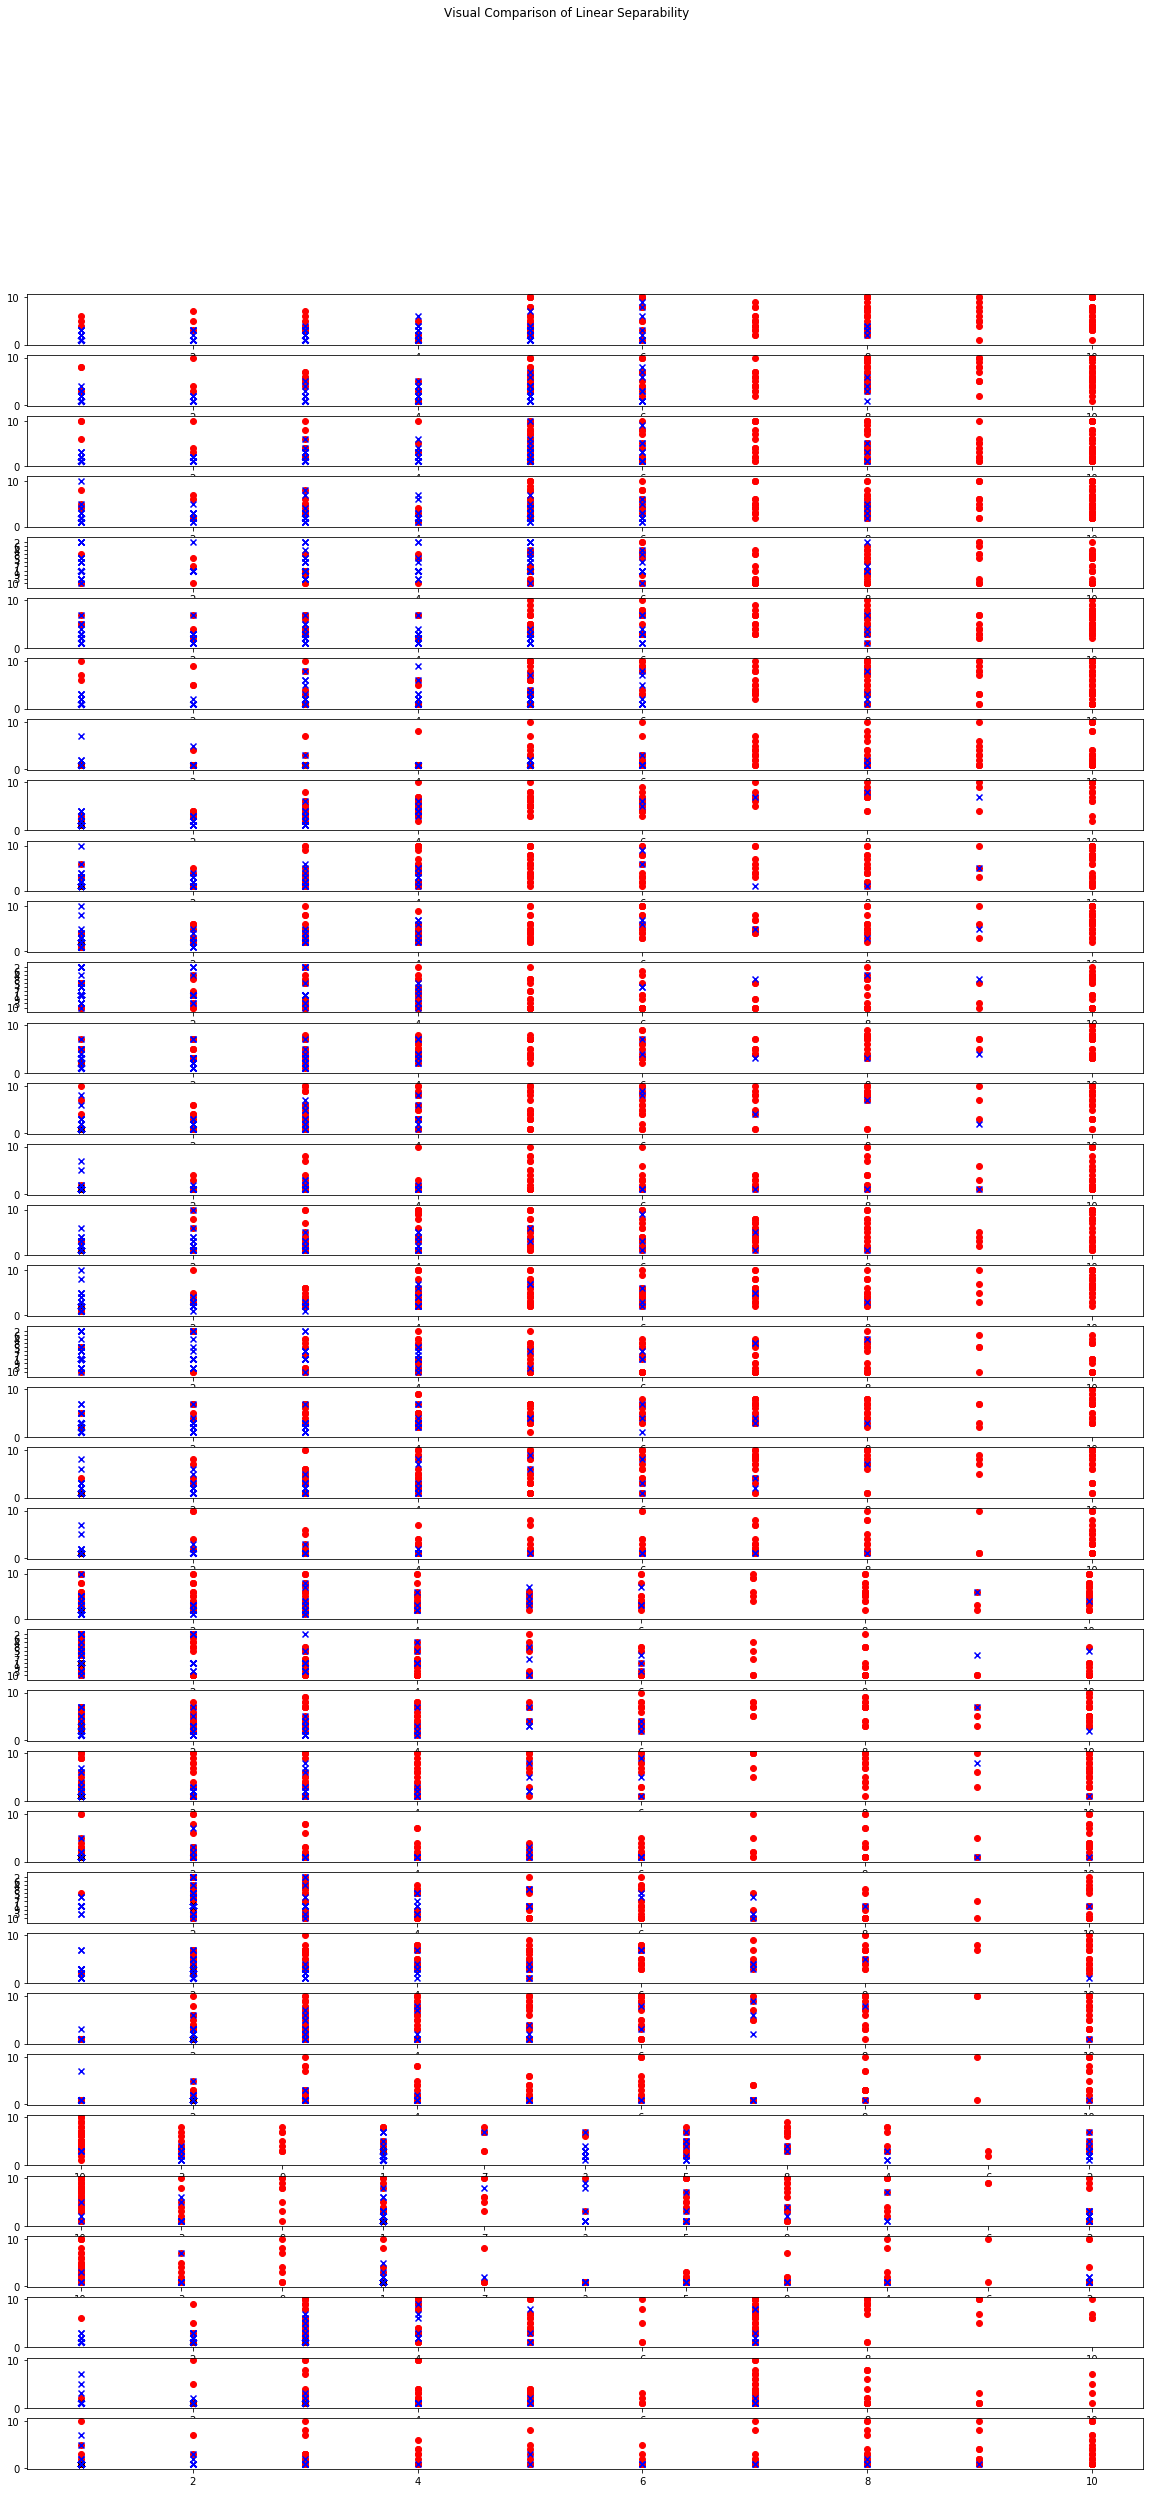

In [17]:
def every_unique_pair(mylist):
    """returns every positionally unique pair in a given list: assumes that no elements in the list appear more than once"""
    ret_list = []
    list_copy = mylist[1:].copy()
    for i in mylist:
        for j in list_copy:
            ret_list.append([i,j])
        list_copy = list_copy[1:]
    return ret_list

figure,subplotx = pp.subplots(len(every_unique_pair(cancer_data.columns[1:len(cancer_data.columns)-1])))
figure.suptitle('Visual Comparison of Linear Separability')
figure.set_size_inches(20, 40)
for i, pair in enumerate(every_unique_pair(cancer_data.columns[1:len(cancer_data.columns) - 1])):
    c1,c2 = pair
    plot_classes_by_columns(subplotx[i], cancer_data, c1, c2)

## Perceptron Class
### As Implemented in Ch02

In [6]:
class perceptron(object):
    """perceptron linear classifier"""
    
    def __init__(self, learning_rate=0.1, epochs=50, random_seed=1):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.random_seed = random_seed
    
    def fit (self, X, y):
        unnormalized_weights = np.random.RandomState(self.random_seed)
        self.weights = unnormalized_weights.normal(loc=0.0, scale=0.1, size= 1 + X.shape[1]) # initialize weights to small random numbers
    
        self.errors_ = [] # Will keep track of the number of missclassifications
    
        for _ in range(self.epochs): #iterate over the data set epochs times
            errors = 0
            for xi, target in zip(X, y):
                delta_weights = self.learning_rate * (target - self.predict(xi)) # compare the predicted value to the desired, and determine change in weights
                self.weights[1:] += delta_weights * xi # all weights by delta_weights
                self.weights[0] += delta_weights # update bias unit
                errors += int(delta_weights != 0.0) # add 1 to the number of errors if the weight changed: otherwise add 0
            self.errors_.append(errors) # append number of errors to errors list so we can plot convergence later
        return self
    
    def net_input (self, X):
        """calculate net input"""
        return np.dot(X, self.weights[1:]) + self.weights[0]
    
    def predict (self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

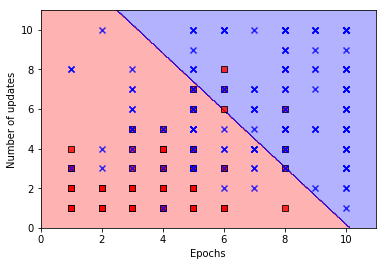

## Fns to determine accuracy and missclassifications

In [44]:
def accuracy_and_misclasses(prediction, labels):
    """Fn to determine accuracy"""
    missclassifications = 0
    correct_predictions = len(labels)
    for a,b in zip(prediction, labels):
        if a != b:
            missclassifications += 1
            correct_predictions -= 1
    return (correct_predictions / len(labels), missclassifications)

## Fn to plot the feature points and the linear seperator

In [20]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):
    """Fn to plot the feature points and the linear seperator"""

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    pp.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    pp.xlim(xx1.min(), xx1.max())
    pp.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        pp.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

In [136]:
def split_fit_test(c1, c2, testtrain_ratio, dataframe=cancer_data, verbose=False, learning_rate=0.1, epochs=50):
    """split data from feature columns c1 and c2 into train and test sets at tt_ratio proportions and fit/test a perceptron"""
    
    # get the integer indeces corresponding to the column names passed to split_fit_test
    c1_idx = dataframe.columns.get_loc(c1)
    c2_idx = dataframe.columns.get_loc(c2)
    
    # number of rows of dataframe which will belong to the training set (we know the number in the test set from this implicitly)
    num_train = len(dataframe.index) - int(len(dataframe.index) * testtrain_ratio)
    
    # Training set
    y_train = cancer_data.iloc[:num_train,10].values # the array of target values: 2 for benign, 4 for malignant
    y_train = np.where(y_train == 2, -1, 1) # change class labels 2 and 4 to -1 and 1 respectively
    X_train = cancer_data.iloc[:num_train, [c1_idx,c2_idx]].values
    
    # Testing set
    y_test = cancer_data.iloc[num_train:,10].values # analagous to above
    y_test = np.where(y_test == 2, -1, 1)
    X_test = cancer_data.iloc[num_train:, [c1_idx, c2_idx]].values
    
    tron = perceptron(learning_rate=learning_rate, epochs=epochs)
    tron.fit(X_train, y_train)
    
    prediction = tron.predict(X_test)
    accuracy,misclasses = accuracy_and_misclasses(prediction, y_test)
    if verbose:
        print("For features", c1, "and", c2, ", and test/train ratio", testtrain_ratio, "the perceptron had", misclasses, "missclassifications and had an accuracy of", accuracy, "\n")
    return (accuracy, misclasses)
    

## First pass: maximize accuracy by feature pairs

In [134]:
best_accuracy = 0
best_pair = None
misses = 0
for c1,c2 in every_unique_pair(cancer_data.columns[1:10]):
    if c1 != 'bare nuclei' and c2 != 'bare nuclei': # bare nuclei contains a null value
        acc,miss = split_fit_test(c1, c2, 0.3)
        if acc > best_accuracy:
            best_accuracy = acc
            best_pair = (c1, c2)
            misses = miss
            
            
print("The highest accuracy was", best_accuracy, "for the feature pair", c1, "and", c2, "with", misses, "missclassifications.")

The highest accuracy was 0.9856459330143541 for the feature pair normal nucleoi and mitoses with 3 missclassifications.


Looking at the results of this function above, the pair of normal nucleoi and mitoses seems to be the best option. However, when applied to predict the training set again, 'normal nucleoi'+'mitoses' yields an abysmal 32% accuracy. For this reason, I chose a feature pair with reasonable accuracy as well as a decent amount of variability and linear separability within/between the two features. Hence the 'thickness' and 'shape uniformity' pair: 

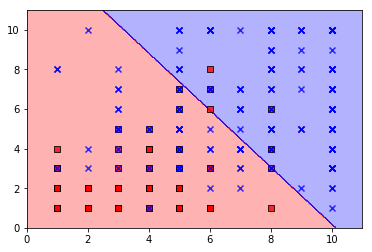

In [131]:
y_train = cancer_data.iloc[:466,10].values # the array of target values: 2 for benign, 4 for malignant

y_train = np.where(y_train == 2, -1, 1) # change class labels 2 and 4 to -1 and 1 respectively

y_test = cancer_data.iloc[466:,10].values
y_test = np.where(y_test == 2, -1, 1)

X_train = cancer_data.iloc[:466, [1,3]].values
X_test = cancer_data.iloc[466:, [1, 3]].values

tron = perceptron()
tron.fit(X_train,y_train)
plot_decision_regions(X_train, y_train, tron)

## Second pass: maximize accuracy by test/train set proportions

In [133]:
best_accuracy = 0
misses = 0
best_prop = 0
 
for prop in [0.25, 0.3, 0.35, 0.40, 0.45]:
    acc,miss = split_fit_test('thickness', 'shape uniformity', prop)
    if acc > best_accuracy:
        best_accuracy = acc
        misses = miss
        best_prop = prop
        
        
print("The highest accuracy was", best_accuracy, "for test/train proportion", best_prop, "with", misses, "missclassifications.")

The highest accuracy was 0.9713261648745519 for test/train proportion 0.4 with 8 missclassifications.


We got the highest accuracy with the test/train proportion of 4/10

## Third pass: maximize accuracy by learning rate

In [139]:
best_accuracy = 0
misses = 0
best_rate = 0

for rate in [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4]:
    acc,miss = split_fit_test('thickness', 'shape uniformity', 0.4, learning_rate=rate)
    if acc > best_accuracy:
        best_accuracy = acc
        misses = miss
        best_rate = rate

print("The highest accuracy was", best_accuracy, "for learning rate", best_rate, "with", misses, "missclassifications.")

The highest accuracy was 0.9713261648745519 for learning rate 0.1 with 8 missclassifications.


## Fourth pass: Maximize accuracy by number of epochs

In [140]:
best_accuracy = 0
misses = 0
best_num_epochs = 0

for n in [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4]:
    acc,miss = split_fit_test('thickness', 'shape uniformity', 0.4, epochs=n)
    if acc > best_accuracy:
        best_accuracy = acc
        misses = miss
        best_num_epochs = n

print("The highest accuracy was", best_accuracy, "for", best_num_epochs, "epochs with", misses, "missclassifications.")

TypeError: 'float' object cannot be interpreted as an integer